# Analysing Environmental 'Big Data' The Great Barrier Reef

#### notes: 
    
the mini-pracs should take no more than 25 minutes, ideally with a mixture of into lecture (~10 mins) and then the remainder of the time for students to do something interactive. The goal here is to highlight some really cool Exeter research you're doing, ideally with some links to potential dissertation research projects and/or 3rd year modules -- at the end of the practical students would ideally be excited about opportunities to learn/research at Exeter.

## Introduction

Example task:

Projections for GBRMPA

Note to Paul. script in /Users/ph290/Documents/HalloranSync/documents/jupyter_github/Jupiter_notebooks_halloran

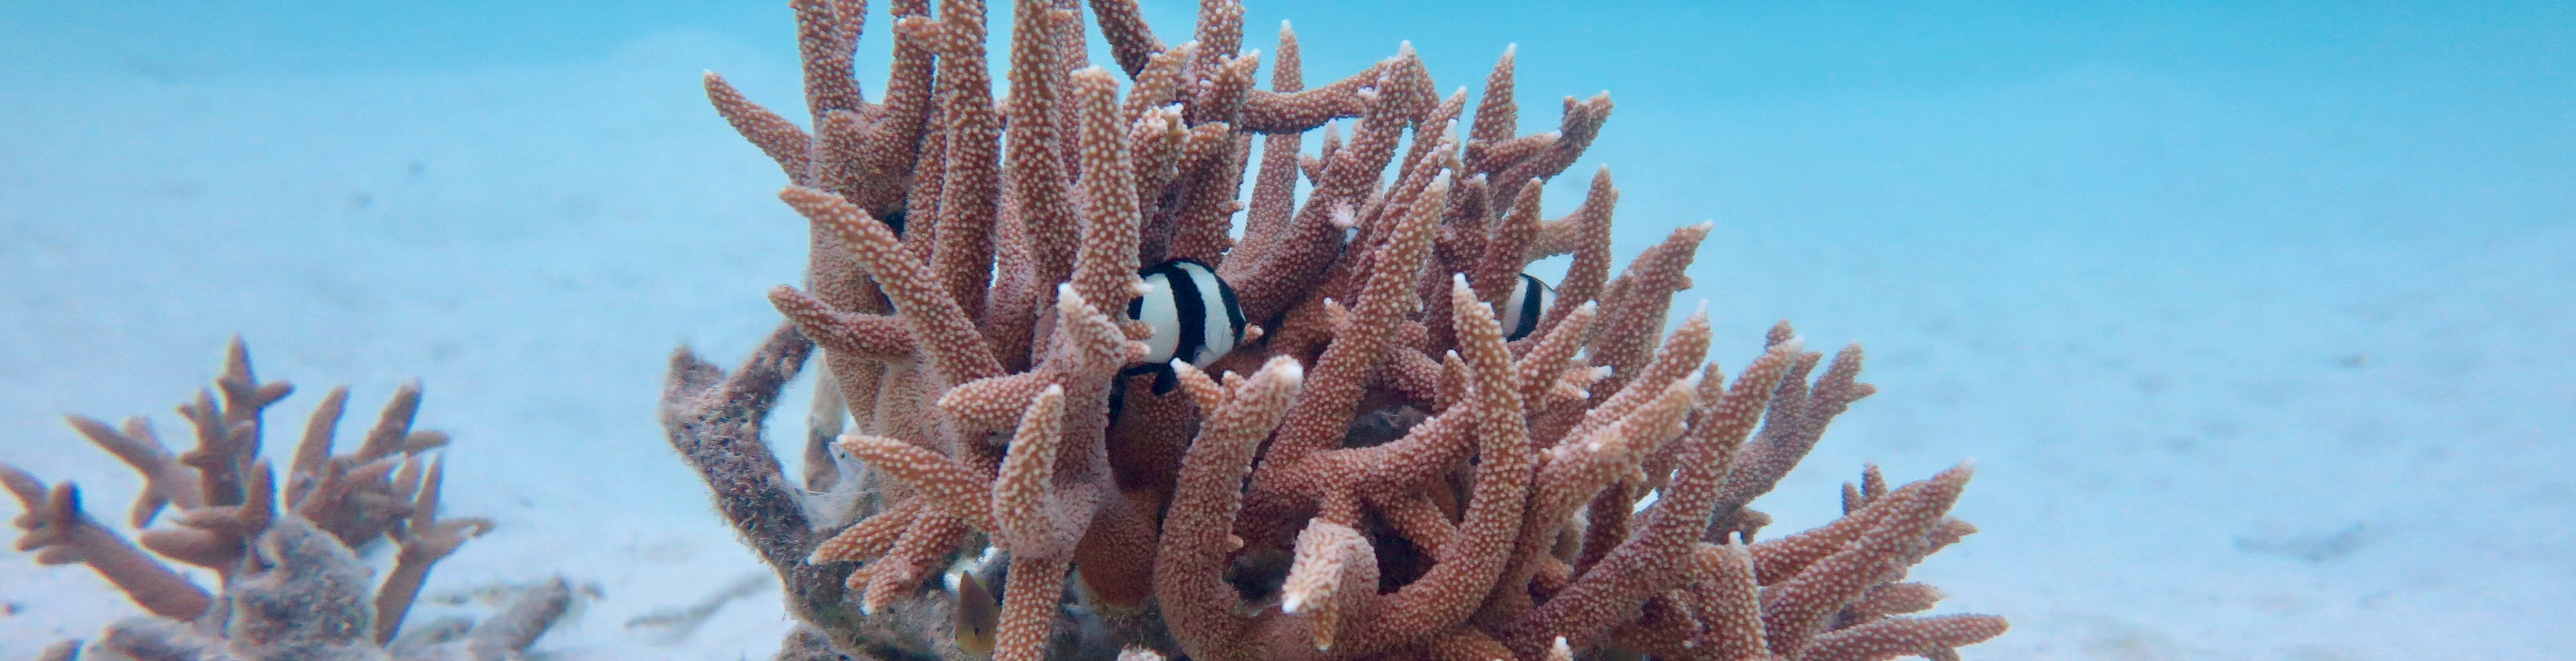

In [45]:
from IPython.display import Image
Image(filename='images/IMG_4919.jpeg') 

## Setup
This section imports some bits of code we will use later. If you're interested in what is going on behind the scenes, let me know.

In [46]:
import iris
import iris.quickplot as qplt
import iris.plot as iplt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy
import plot_north_south_depth_section
import plot_east_west_depth_section
import plot_different_vertical_levels
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=UserWarning)




In [ ]:
def mmm_skirving(cube):
    cube = cube.aggregated_by(['year','month'], iris.analysis.MEAN)
    print 'calculating NOAA Skirving MMM for month:'
#     missing_data_value_greater_than = -32768.0
#     missing_data_equals = -32768.0
    missing_data_equals = cube.data.fill_value
    print 'NOTE THIS SHOULD IDEALLY BE USING AN AVERAGE OF NIGHTIME TEMPERATURES, WHICH IS NOT A BED ESTIMATE FOR DAILY MEAN. A GOOD ALTERNATIEV FOR DAILY MEAN IS 10am (whet chris merchant does)'
    years_for_mmm_climatology = [1985,2012]
    standardisation_date = 1988.2857
    mm_cube = cube[0:12].copy()
    mm_cube_data = mm_cube.data.copy()
    cube_years = cube.coord('year').points
    #subset the data into the bit you want to use to calculate the MMM climatology and the bit you want to calculate DHW on
    clim_cube = cube[np.where((cube_years >= years_for_mmm_climatology[0]) & (cube_years <= years_for_mmm_climatology[1]))]
    clim_cube_detrended = clim_cube.copy()
    clim_cube_detrended_data = clim_cube_detrended.data
    print np.shape(clim_cube_detrended)
    for i,month in enumerate(np.unique(cube.coord('month_number').points)):
        print i+1
        loc = np.where(clim_cube.coord('month_number').points == month)
        tmp = clim_cube_detrended_data[loc,:,:][0]
        tmp[np.where(tmp == missing_data_equals )] = np.nan
        slope,intercept = linregress_3D(tmp)
        x = standardisation_date - years_for_mmm_climatology[0]
        y = (slope * x ) + intercept
        mm_cube_data[i,:,:] = y
    mm_cube.data = mm_cube_data
    mmm_climatology = mm_cube.collapsed('time',iris.analysis.MAX)
    return mmm_climatology


def dhw(cube,mmm_climatology,years_over_which_to_calculate_dhw):
    cube_years = cube.coord('year').points
    #note this is to be uef with daily data...
    main_cube = cube[np.where((cube_years > years_over_which_to_calculate_dhw[0]) & (cube_years < years_over_which_to_calculate_dhw[1]))]
    #subtract the monthly mean climatology from the rest of the data
    main_cube -= mmm_climatology
    #set all values less than 1 to zero
    main_cube.data[np.where(main_cube.data < 1.0)] = 0.0 

    #make a cube to hold the output data
    output_cube = main_cube[83::].copy()
    output_cube.data[:] = np.nan
    output_cube_data = output_cube.data.copy()

    #loop through from day 84 to the end of the dataset
    for i in range(output_cube.shape[0]):
#         print i,' of ',output_cube.shape[0]
        #sum the temperatures in that 84 day window and divide result by 7 to get in DHWeeks rather than DHdays
        tmp_data = main_cube[i:i+84].collapsed('time',iris.analysis.SUM)/7.0
        output_cube_data[i,:,:] = tmp_data.data

    #save the output
    output_cube.data = output_cube_data
    return output_cube

Here we are reading in the dataset we want to interrogate

In [53]:
cube = iris.load_cube('data/gbrish_era5_surfacetemperature.nc') # this 
cube.data = np.ma.masked_where(cube.data > 1.0e35,cube.data)

cube_bottom = iris.load_cube('data/gbrish_era5_bottomtemperature.nc') # this 
cube_bottom.data = np.ma.masked_where(cube_bottom.data > 1.0e35,cube_bottom.data)

## Analysing the data

The three plots below allow you to explore the dataset. 
Edit the numbers in green, and re-run the script (>>) and explore what the plots are telling you


-----------------------------------

### Plot data at a certain depth level

In [48]:
depth = 200 # depth in meters

The code below produces the plot. Note, white areas are where there is no data - typically land.

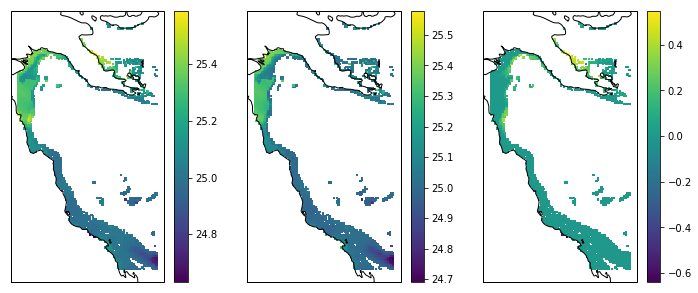

In [55]:
plt.figure(figsize=(12, 5))

day=0

plt.subplot(131)
iplt.pcolormesh(cube[day])
plt.gca().coastlines('50m')
plt.colorbar(orientation='vertical')

plt.subplot(132)
iplt.pcolormesh(cube_bottom[day])
plt.gca().coastlines('50m')
plt.colorbar(orientation='vertical')

plt.subplot(133)
iplt.pcolormesh(cube[day] - cube_bottom[day])
plt.gca().coastlines('50m')
plt.colorbar(orientation='vertical')

-----------------------------------

### Latitude v. depth plots
Specify the latitude and longitude values that describe the region you want to explore, then run the script (>>) and examine the plot.

In [5]:
westernmost_longitude = -60.0 # this should be a value between -180 and 180 degrees
easternmost_longitude = -50.0 # this should be a value between -180 and 180 degrees
southernmost_latitude = -90 # this should be a value between -90 and 90 degrees
northernmost_latitude = 90 # this should be a value between -90 and 90 degrees

The code below produces the plot. Note, white areas are where there is no data - typically land.

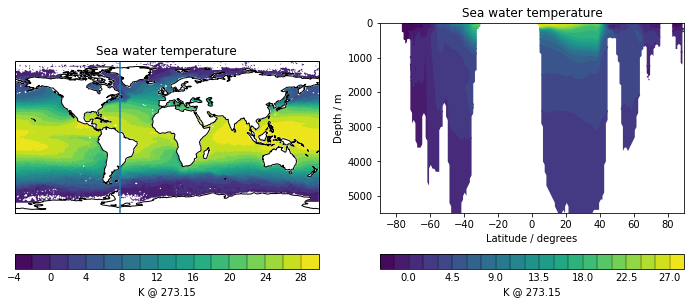

In [6]:
plot_north_south_depth_section.plot(westernmost_longitude,easternmost_longitude,southernmost_latitude,northernmost_latitude,cube)

Play with the latitude and longitude values in the box below, then run the script to plot up East-West sections down through the ocean for those regions

-----------------------------------

### Longitude v. depth plots
Specify the latitude and longitude values that describe the region you want to explore, then run the script (>>) and examine the plot.

In [11]:
westernmost_longitude = -180 # this should be a value between -180 and 180 degrees
easternmost_longitude = 180 # this should be a value between -180 and 180 degrees
southernmost_latitude = -5 # this should be a value between -90 and 90 degrees
northernmost_latitude = 5 # this should be a value between -90 and 90 degrees

The code below produces the plot. Note, white areas are where there is no data - typically land.

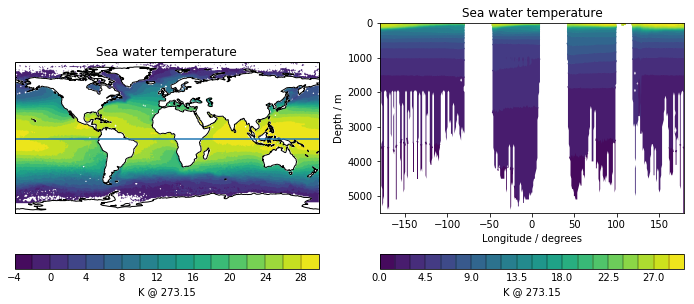

In [12]:
plot_east_west_depth_section.plot(westernmost_longitude,easternmost_longitude,southernmost_latitude,northernmost_latitude,cube)